<a href="https://colab.research.google.com/github/mikolaura/ObjectDetectionMultipleObjects/blob/main/ObjectDetectionUsingMultipleClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib
# If you are in the sub directory of "models" directory, move to the "models" directory. If not, clone it.
if "models" in pathlib.Path.cwd().parts:
   while "models" in pathlib.Path.cwd().parts:
     os.chdir('..')
elif not pathlib.Path('models').exists():
   !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (3077/3077), done.
remote: Total 4084 (delta 1185), reused 1989 (delta 947), pack-reused 0
Receiving objects: 100% (4084/4084), 44.62 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.
Updating files: 100% (3696/3696), done.


In [ ]:
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

In [ ]:
%%shell
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 21.0 MB/s eta

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="fKlenx0IEDMDwmJ7KNzq")
project = rf.workspace("wildlifealert-zkdxf").project("wildlifethirdeye")
version = project.version(5)
dataset = version.download("tensorflow")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to WildLifeThirdEye-5 in tensorflow:: 100%|██████████| 48/48 [00:00<00:00, 3964.53it/s]


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz # you can get the URLs of other models in the link above.
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-04-06 07:46:39--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.96.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  37.9MB/s    in 6.9s    

2024-04-06 07:46:47 (33.7 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
def load_image_into_numpy_array(path):

  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [ ]:
import csv
def read_images_from_csv(file_path, path_without_annotations):
  with open(file_path, 'r') as csv_filepath:
    reader = csv.reader(csv_filepath)
    next(reader)
    images = []
    labels = []
    bbox = []
    for row in reader:
      image_path = path_without_annotations + row[0]
      width = int(row[1])
      height = int(row[2])
      class_type = 0 if row[3] == 'Tiger' else 1
      xmin = int(row[4] )
      ymin = int(row[5])
      xmax = int(row[6])
      ymax = int(row[7])
      xmin /= width
      ymin /= height
      xmax /= width
      ymax /= height
      image = load_image_into_numpy_array(image_path)
      bbox.append(np.array([[xmin, ymin, xmax, ymax]]))
      labels.append(np.array([class_type]))
      images.append(image)
    return images, bbox, labels

In [ ]:
category_index = {
     0: {'id': 0, 'name': 'Tiger'},
     1: {'id': 1, 'name': 'Elephant'}
     }

train_images_np, gt_boxes, gt_labels = read_images_from_csv('/content/tigers/train/_annotations.csv', '/content/tigers/train/')

In [ ]:
width = height = 640

In [ ]:
gt_boxes

[array([[0.184375 , 0.79375  , 0.3296875, 0.9984375]]),
 array([[0.478125 , 0.440625 , 0.784375 , 0.6953125]]),
 array([[0.2328125, 0.3828125, 0.46875  , 0.7      ]]),
 array([[0.0796875, 0.26875  , 0.8578125, 0.6953125]]),
 array([[0.0921875, 0.2140625, 0.815625 , 0.7953125]]),
 array([[0.0890625, 0.1109375, 0.5984375, 0.8      ]]),
 array([[0.6015625, 0.4015625, 0.9984375, 0.825    ]]),
 array([[0.040625 , 0.4203125, 0.384375 , 0.659375 ]]),
 array([[0.5921875, 0.53125  , 0.9734375, 0.6828125]]),
 array([[0.2515625, 0.184375 , 0.4609375, 0.371875 ]]),
 array([[0.4640625, 0.334375 , 0.525    , 0.421875 ]]),
 array([[0.5      , 0.565625 , 0.6578125, 0.740625 ]]),
 array([[0.640625, 0.459375, 0.81875 , 0.703125]]),
 array([[0.3390625, 0.5390625, 0.425    , 0.603125 ]]),
 array([[0.1375   , 0.8078125, 0.2921875, 0.91875  ]]),
 array([[0.384375 , 0.8078125, 0.4984375, 0.9265625]]),
 array([[0.       , 0.7828125, 0.1140625, 0.8921875]]),
 array([[0.1328125, 0.7328125, 0.215625 , 0.825    ]

In [ ]:
num_classes = 2
label_id_offset = 0
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, gt_label_np) in zip(
     train_images_np, gt_boxes, gt_labels):

   train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
       train_image_np, dtype=tf.float32), axis=0)) # put images in tensor
   gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32)) # put box in Tensor
   zero_indexed_groundtruth_classes = tf.convert_to_tensor(
       gt_label_np - label_id_offset) # put labels in Numpy array (min:0)
   gt_classes_one_hot_tensors.append(tf.one_hot(
       zero_indexed_groundtruth_classes, num_classes)) # label Tensor to one hot
print('Done prepping data.')

Done prepping data.


In [ ]:
tf.keras.backend.clear_session()
print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 2 # number of classes of your dataset
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, override the `num_classes` field here.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image (array of zero) so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


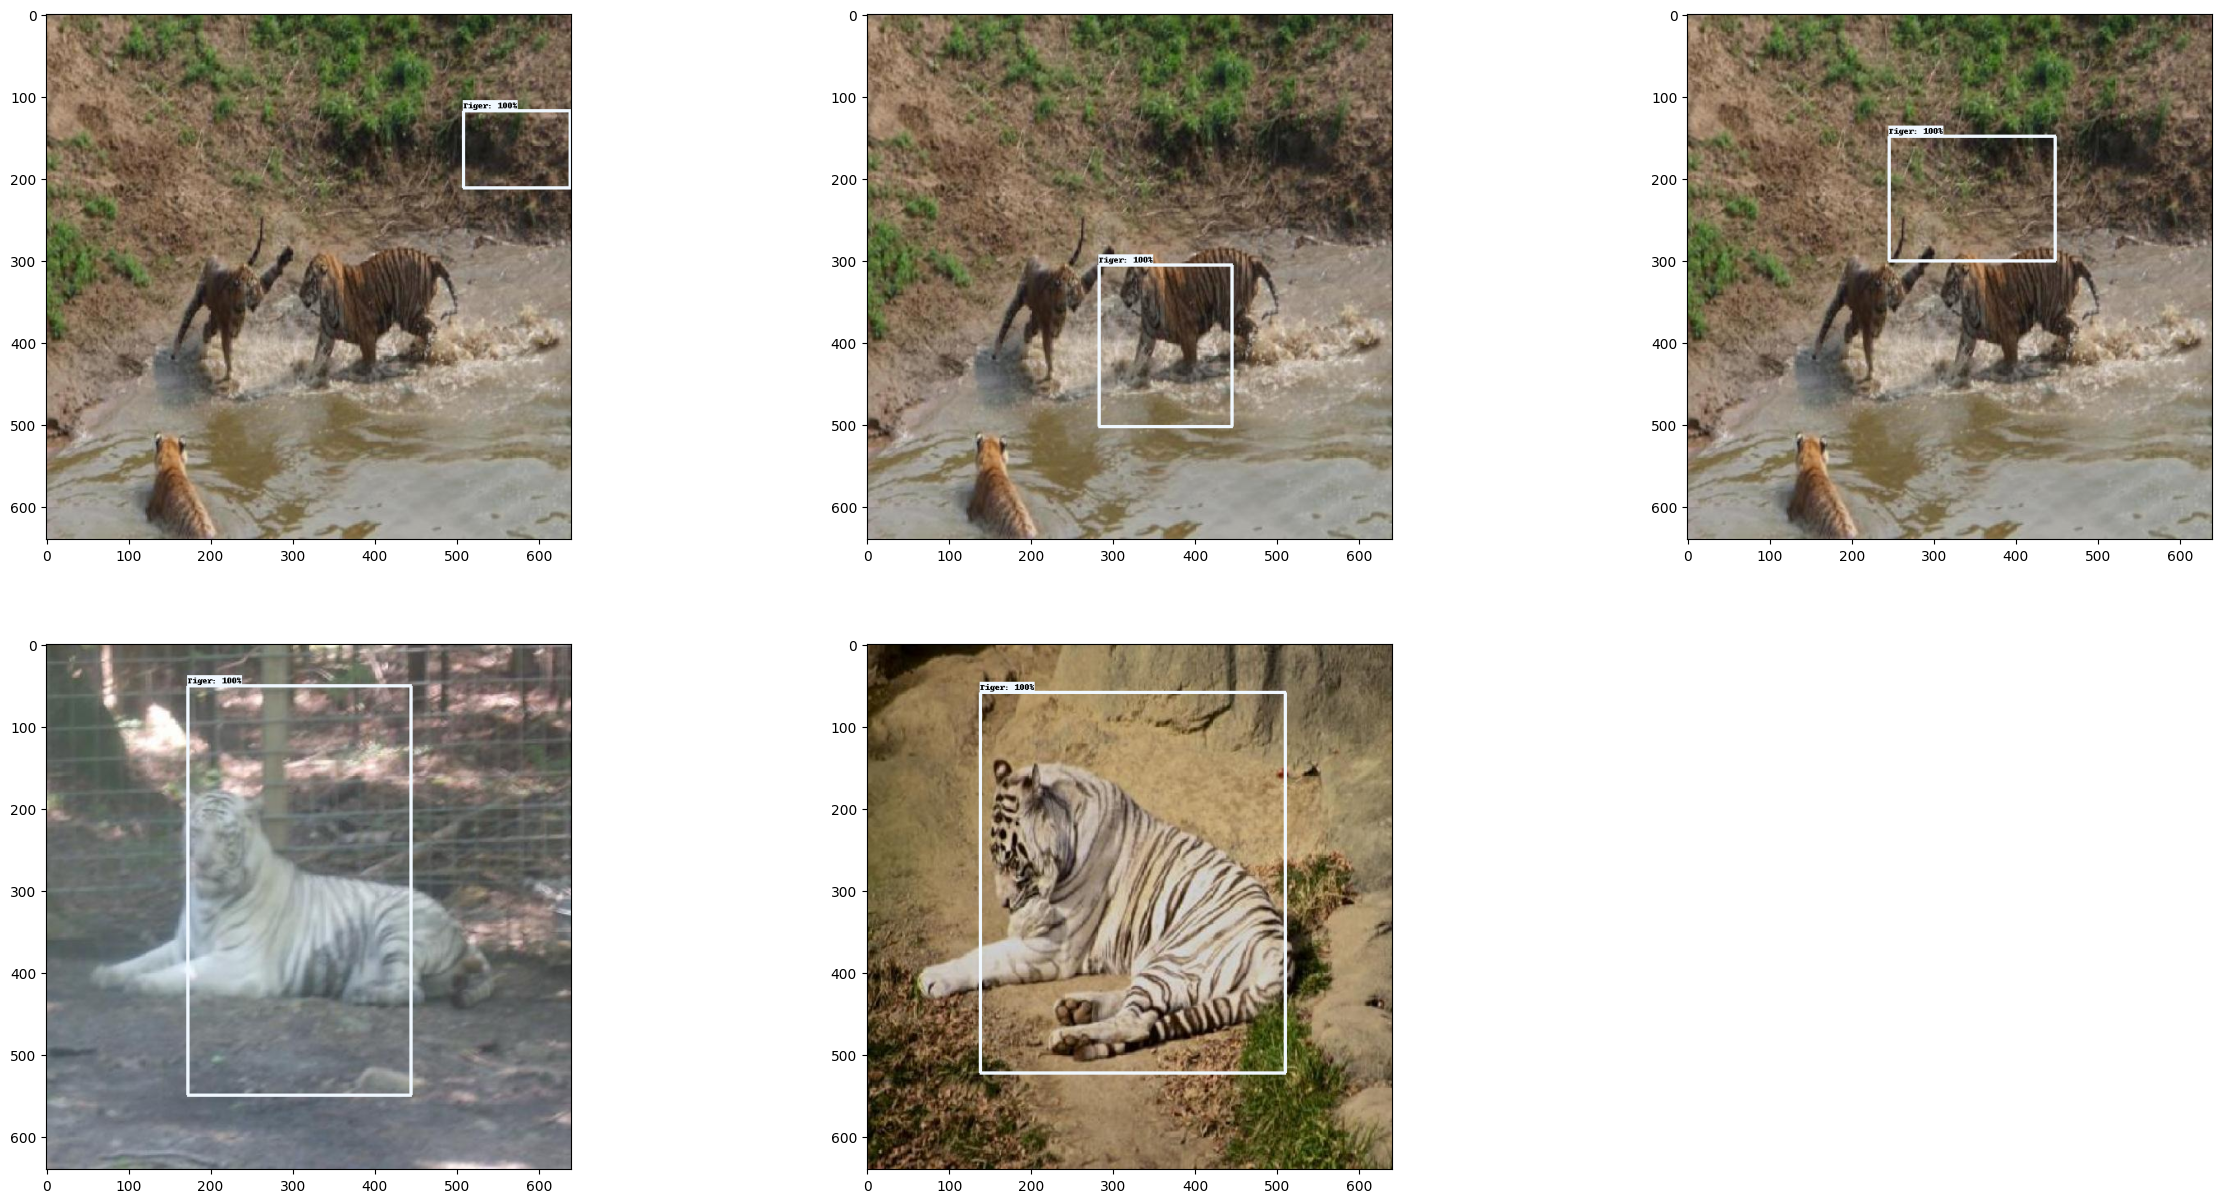

In [ ]:
def plot_detections(image_np,
                     boxes,
                     classes,
                     scores,
                     category_index,
                     figsize=(12, 16),
                     image_name=None):

  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.2)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
dummy_scores = np.array([1.0], dtype=np.float32) # Temporarily put 100% scores
plt.figure(figsize=(30, 15))
for idx in range(5):
   plt.subplot(2, 3, idx+1)
   plot_detections(
       train_images_np[idx],
       gt_boxes[idx],
       gt_labels[idx],
       dummy_scores, category_index)
plt.show()

In [ ]:
tf.keras.backend.set_learning_phase(True)
import random
# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for epoch in range(10):
  for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Note that we do not do data augmentation in this demo.  If you want a
    # a fun exercise, we recommend experimenting with random horizontal flipping
    # and random cropping :)
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
      print('batch ' + str(idx) + ' of ' + str(num_batches)
      + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


batch 0 of 100, loss=1.8728818
batch 10 of 100, loss=1.9426785
batch 20 of 100, loss=0.9721397
batch 30 of 100, loss=1.6897216
batch 40 of 100, loss=1.7771908
batch 50 of 100, loss=1.7072649
batch 60 of 100, loss=1.3970469
batch 70 of 100, loss=1.1272234
batch 80 of 100, loss=1.3001645
batch 90 of 100, loss=1.1937202
batch 0 of 100, loss=1.2499871
batch 10 of 100, loss=1.4251041
batch 20 of 100, loss=1.9637133
batch 30 of 100, loss=3.017608
batch 40 of 100, loss=2.2638273
batch 50 of 100, loss=1.6386786
batch 60 of 100, loss=2.55486
batch 70 of 100, loss=2.9687374
batch 80 of 100, loss=1.6763366
batch 90 of 100, loss=4.40093
batch 0 of 100, loss=2.9891496
batch 10 of 100, loss=2.614297
batch 20 of 100, loss=2.7439017
batch 30 of 100, loss=2.5908284
batch 40 of 100, loss=1.4993935
batch 50 of 100, loss=1.9840386
batch 60 of 100, loss=2.9779453
batch 70 of 100, loss=2.3726954
batch 80 of 100, loss=1.0879622
batch 90 of 100, loss=1.9747351
batch 0 of 100, loss=1.4201714
batch 10 of 100, l

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
def plot_prediction_on_cv2(image, boxes, classes, scores):
  for bbox in range(len(boxes)):
    if scores[bbox ] > 0.5:
      xmin= int(boxes[bbox][0] *640)
      ymin = int(boxes[bbox][1] * 640)
      xmax = int(boxes[bbox][2] * 640)
      ymax = int(boxes[bbox][3] * 640)
      start_point = (100, 50)
      end_point = (125, 80)
      cv2.putText(image,
                 category_index[classes[bbox]]['name'] + f" Score {scores[bbox]*100}%",
                 (xmin + 10, ymin- 35),
                 cv2.FONT_HERSHEY_SIMPLEX ,
                 1,
                 (0, 0, 0) ,
                  5
                 )
      cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 5)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

In [ ]:
test_images_np, test_gt_boxes, test_gt_labels = read_images_from_csv('/content/tigers/valid/_annotations.csv', '/content/tigers/valid/')

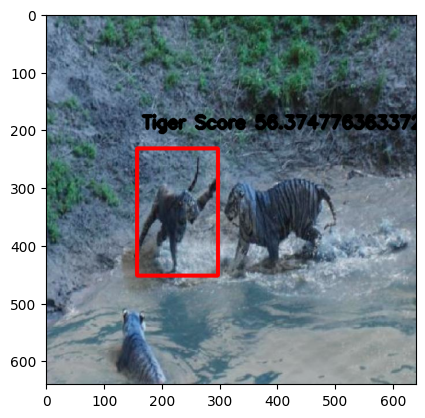

In [ ]:
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return  detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
plt.imshow(train_images_np[1])
image_test = load_image_into_numpy_array("img.jpg")
input_tensor = tf.convert_to_tensor(train_images_np[1], dtype=tf.float32)
input_tensor = tf.expand_dims(input_tensor, axis=0)

detections =detect(input_tensor)
image = plot_prediction_on_cv2(
    train_images_np[1],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32),
    detections['detection_scores'][0].numpy())

plt.imshow(image)

In [ ]:

detections['detection_scores'][0].numpy()


array([0.17720763, 0.14777634, 0.1447853 , 0.140463  , 0.13504586,
       0.12724943, 0.12641641, 0.12610704, 0.12476187, 0.12400188,
       0.12395211, 0.12385201, 0.12124372, 0.11840242, 0.11790302,
       0.11742372, 0.11336258, 0.11293688, 0.11165716, 0.11097997,
       0.11027303, 0.10918589, 0.10879148, 0.10858386, 0.10778049,
       0.10754874, 0.1067307 , 0.10666594, 0.10642579, 0.10631636,
       0.10522905, 0.10380247, 0.10340064, 0.10308635, 0.10282387,
       0.10247208, 0.10177685, 0.10084033, 0.10082665, 0.10072666,
       0.10056864, 0.100475  , 0.10032772, 0.09982315, 0.09972373,
       0.09968644, 0.09939611, 0.09867927, 0.09866027, 0.09860627,
       0.09767685, 0.09741832, 0.09685966, 0.0962532 , 0.09620139,
       0.09597667, 0.09572997, 0.09569187, 0.0956434 , 0.09486653,
       0.09484733, 0.09458444, 0.09445223, 0.09422642, 0.09317023,
       0.09278505, 0.09275455, 0.09204911, 0.09190339, 0.09178283,
       0.09134746, 0.09122767, 0.09107815, 0.0909736 , 0.09078

In [212]:
import os
detection_model.get_weights()

[array([[[[-2.79928055e-02,  4.65434864e-02, -5.49133075e-03, ...,
           -4.04041931e-02,  5.36493165e-03, -6.35524606e-03],
          [ 1.22922286e-02,  1.85777768e-02,  9.13888309e-03, ...,
            1.24364840e-02, -1.59269688e-03, -1.52980618e-04],
          [ 1.45643335e-02,  3.41803916e-02, -2.23079789e-02, ...,
            1.86533015e-02, -2.46072561e-02,  5.27386926e-03],
          ...,
          [ 3.20520587e-02, -4.04994143e-03,  2.13842168e-02, ...,
            1.52343120e-02, -3.63337342e-03,  3.85370152e-03],
          [ 2.97302031e-03, -2.27279235e-02,  5.49178459e-02, ...,
           -1.39670409e-02,  1.82184614e-02, -2.27717962e-02],
          [-6.42743427e-03, -2.56245933e-03, -1.35982763e-02, ...,
            1.12206424e-02,  2.23902613e-02, -4.99526178e-03]],
 
         [[-1.56048834e-02, -5.31383231e-02,  3.44406301e-03, ...,
           -1.66784246e-02,  2.27136351e-02,  1.18123293e-02],
          [ 5.71279489e-02, -1.46598062e-02,  3.20273153e-02, ...,
     

In [218]:
detection_model.build((640, 640, 3))
tf.saved_model.save(detection_model, 'model_name', signatures=None, options=None)

In [219]:
!zip -r /content/file.zip /content/model_name


  adding: content/model_name/ (stored 0%)
  adding: content/model_name/variables/ (stored 0%)
  adding: content/model_name/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model_name/variables/variables.index (deflated 79%)
  adding: content/model_name/fingerprint.pb (stored 0%)
  adding: content/model_name/saved_model.pb (deflated 92%)
  adding: content/model_name/assets/ (stored 0%)


In [225]:
graph = tf.Graph()
with graph.as_default():
    sess = tf.compat.v1.Session()
    with sess.as_default():
        # creating the model/loading it from a TF2 pb file
        # (If you have a keras model, you can use
        #`tf.keras.models.load_model` instead).
        model = tf.saved_model.load("model_name")

# the default signature might be different.
sign = model.signatures["serving_default"]
# if using keras, just use model.outputs
tensor_out_names = [out.name.split(":")[0] for out in sign.outputs]

graphdef = tf.compat.v1.graph_util.convert_variables_to_constants(
    sess, graph.as_graph_def(), tensor_out_names
)
# the following is optional, use only if no more training is required
graphdef = tf.compat.v1.graph_util.remove_training_nodes(graphdef)
tf.python.framework.graph_io.write_graph(graphdef, "./", "/path/to/frozengraph", as_text=False)

KeyError: 'serving_default'